# Quality Inspection - Machine Learning Models Benchmark - Xception

## Objective
To test the automation quality inspection using computer vision machine learning models
This repository will benchmark machine learning models (InceptionResNetv2, Xception, ConvNeXt and a Custom model) 

## Dataset

The dataset used is from from Pilot Technocast, a companyn located in Gujarat, India, that specializes in manufacturing casting products. The dataset, consisting of 7348 top-view images of submersible pump impellers made with stainless steel through a shell molding casting process, was made publicly available by Ravirajsinh Dabhi. The images were resized to 300 x 300 pixels and were collected using a Canon EOS 1300D camera kit under stable lighting. The data is pre-labeled into two categories, namely 'def_front' and 'ok_front,' representing defective and acceptable products, respectively.

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.preprocessing import image 
from keras.models import Sequential
from sklearn import metrics

2023-04-22 21:49:42.690833: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Use the GPU on a Mac M1
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# defining dir variables 
root_dir = 'archive/casting_data/casting_data/'
train_defective = root_dir + 'train/def_front/'
train_ok = root_dir + 'train/ok_front/'

test_defective = root_dir + 'test/def_front/'
test_ok = root_dir + 'test/ok_front/'

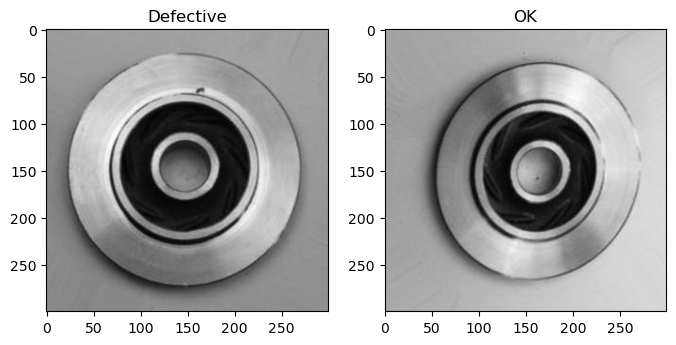

In [4]:
# Ploting images

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].imshow(plt.imread(train_defective+os.listdir(train_defective)[0]))
axes[1].imshow(plt.imread(train_ok+os.listdir(train_ok)[0]))
axes[0].set_title('Defective')
axes[1].set_title('OK')
plt.show()

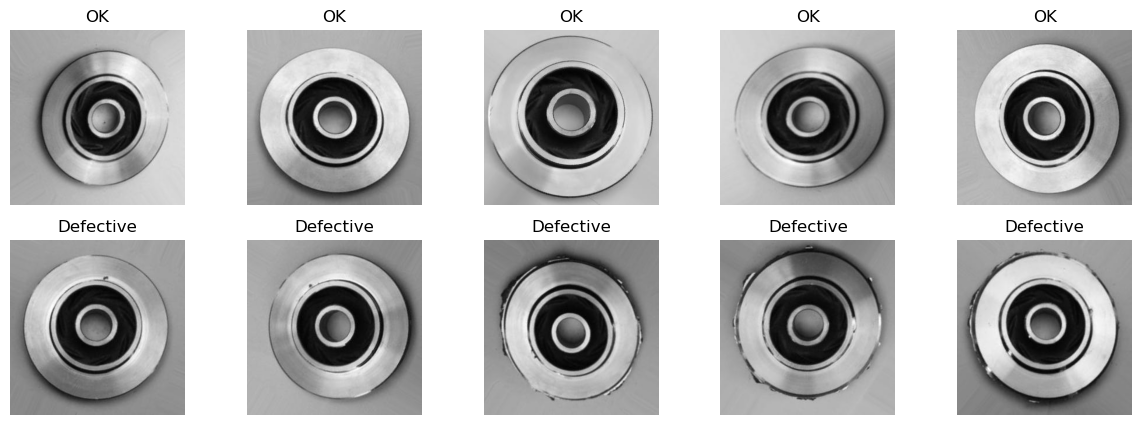

In [5]:
# 5 images from each label - training set

# define the number of images to plot for each label
num_images = 5

# create a figure with two rows and num_images columns
fig, axs = plt.subplots(nrows=2, ncols=num_images, figsize=(15,5))

# plot the ok images
for i, filename in enumerate(os.listdir(train_ok)[:num_images]):
    img = plt.imread(train_ok + filename)
    axs[0,i].imshow(img)
    axs[0,i].set_title('OK')
    axs[0,i].axis('off')

# plot the defective images
for i, filename in enumerate(os.listdir(train_defective)[:num_images]):
    img = plt.imread(train_defective + filename)
    axs[1,i].imshow(img)
    axs[1,i].set_title('Defective')
    axs[1,i].axis('off')

# adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# show the plot
plt.show()


### EDA(Exploratory data analysis)

    - Number of images

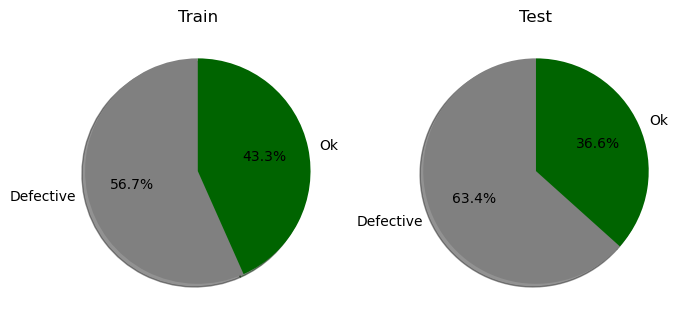

 Defective Training Images 	: 3758
 Ok Training Images 		: 2875

 Defective Testing Images 	: 453
 Ok Testing Images 		: 262


In [6]:
x_train = np.array([len(os.listdir(train_defective)),len(os.listdir(train_ok))])
x_test = np.array([len(os.listdir(test_defective)),len(os.listdir(test_ok))])
label = ['Defective','Ok']
colors = ['grey', 'darkgreen']
  
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%',shadow=True, startangle=90, colors=colors)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%',shadow=True, startangle=90, colors=colors)
axes[0].set_title('Train')
axes[1].set_title('Test')
plt.show()

print(' Defective Training Images \t: ' + str(len(os.listdir(train_defective))))
print(' Ok Training Images \t\t: ' + str(len(os.listdir(train_ok))))
print()
print(' Defective Testing Images \t: ' + str(len(os.listdir(test_defective))))
print(' Ok Testing Images \t\t: ' + str(len(os.listdir(test_ok))))

## Data loading and perprocessing

    - Normalization 
    - Grayscale
    - input shape size for CNN (300x300)

In [7]:

# Using IDG to load images from directory
train_idg = ImageDataGenerator(rescale=1./255, validation_split=0.3) # 30 percent validation split for taining 
test_idg = ImageDataGenerator(rescale=1./255)

# Specify parameters/arguments for data generation
img_size = (300, 300)
batch_size = 64

arg_train = {'target_size': img_size,
             'color_mode': 'rgb',
             'class_mode': 'binary',
             'batch_size': batch_size}
arg_test = {'target_size': img_size,
            'color_mode': 'rgb',
            'class_mode': 'binary',
            'batch_size': batch_size,
            'shuffle': False}

train = train_idg.flow_from_directory(directory=root_dir+'train/', subset='training', **arg_train)
valid = train_idg.flow_from_directory(directory=root_dir+'train/', subset='validation', **arg_train)
test  = test_idg.flow_from_directory(directory=root_dir+'test/', **arg_test)

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


## CNN

In [8]:
from tensorflow.keras.applications import Xception
xcept = Xception(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')

2023-04-22 22:03:32.807176: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-22 22:03:32.807279: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



### Bulding model

In [9]:
import os
import numpy as np
import pandas as pd
import keras
from keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
from keras.preprocessing import image 
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import models
import datetime

for layer in xcept.layers:
    layer.trainable = False

cnn = keras.Sequential([
    xcept,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation="sigmoid"),
])

cnn.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 256)               52429056  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 73,290,793
Trainable params: 52,429,313
Non-trainable params: 20,861,480
_________________________________________________________________


### Training

In [10]:
history = cnn.fit(
    train,
    validation_data=valid,
    epochs=20,
    steps_per_epoch=20,
    verbose = 1
    )

Epoch 1/20


2023-04-22 22:03:53.634008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-22 22:03:56.229339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 13.5174 - accuracy: 0.6102

2023-04-22 22:05:44.119313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-22 22:05:45.286362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 281s 14s/step - loss: 13.5174 - accuracy: 0.6102 - val_loss: 2.2155 - val_accuracy: 0.7350
Epoch 2/20
20/20 [==============================] - 275s 14s/step - loss: 0.7950 - accuracy: 0.8922 - val_loss: 0.1035 - val_accuracy: 0.9708
Epoch 3/20
20/20 [==============================] - 275s 14s/step - loss: 0.1077 - accuracy: 0.9657 - val_loss: 0.0763 - val_accuracy: 0.9718
Epoch 4/20
20/20 [==============================] - 276s 14s/step - loss: 0.0775 - accuracy: 0.9792 - val_loss: 0.0405 - val_accuracy: 0.9864
Epoch 5/20
20/20 [==============================] - 281s 14s/step - loss: 0.0422 - accuracy: 0.9883 - val_loss: 0.0315 - val_accuracy: 0.9910
Epoch 6/20
20/20 [==============================] - 297s 15s/step - loss: 0.0256 - accuracy: 0.9898 - val_loss: 0.0433 - val_accuracy: 0.9879
Epoch 7/20
20/20 [==============================] - 282s 14s/step - loss: 0.0465 - accuracy: 0.9891 - val_loss: 0.0347 - val_accuracy: 0.9889
Epoch 8/20
20/20

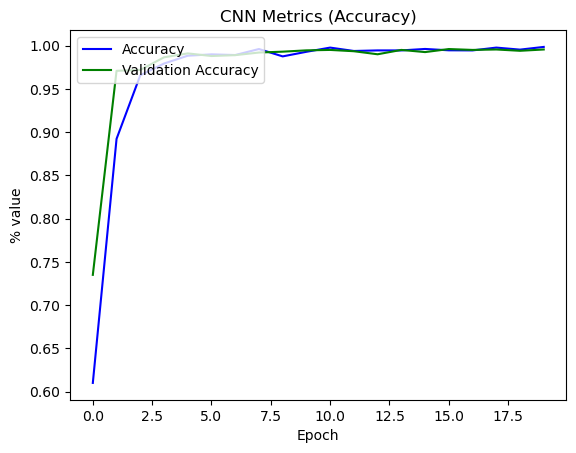

In [11]:
plt.plot(history.history['accuracy'], color='blue', label='Accuracy')
plt.plot(history.history['val_accuracy'], color='green', label='Validation Accuracy')
plt.title('CNN Metrics (Accuracy)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

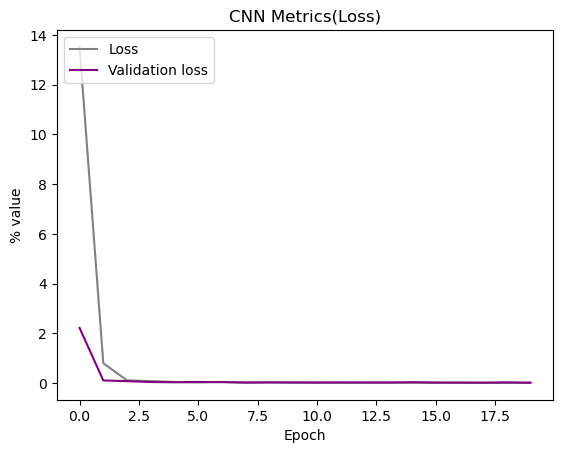

In [12]:
plt.plot(history.history['loss'], color='grey', label='Loss')
plt.plot(history.history['val_loss'], color='purple', label='Validation loss')
plt.title('CNN Metrics(Loss)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

### Testing and evaluation

In [13]:
y_pred = cnn.predict(test)
y_pred = (y_pred >= 0.5).reshape(-1,)

2023-04-22 23:23:25.111305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-22 23:23:25.857443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 40s 3s/step


In [14]:
y_actual = test.classes[test.index_array]

#### Confusion matrix

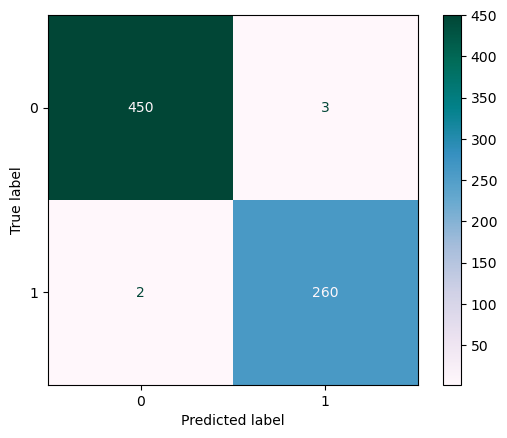

In [15]:
cm = metrics.confusion_matrix(y_actual, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='PuBuGn')
plt.show()

#### Classification report

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9956    0.9934    0.9945       453
           1     0.9886    0.9924    0.9905       262

    accuracy                         0.9930       715
   macro avg     0.9921    0.9929    0.9925       715
weighted avg     0.9930    0.9930    0.9930       715

